In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 120
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
pcmciplus_features = ['LW_down', 'snowfall', 'sst', 'sosaline', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

Day  wind_10m  specific_humidity     LW_down   SW_down  rainfall  \
7305  1/1/1999  4.987515           0.891843  183.786092  1.120906  0.700735   
7306  1/2/1999  5.075952           0.905535  183.851814  1.193514  0.712730   
7307  1/3/1999  4.931520           0.911672  184.426913  1.263909  0.677339   
7308  1/4/1999  4.761644           0.911301  187.528326  1.269229  0.824016   
7309  1/5/1999  4.739850           0.901353  187.326709  1.552208  0.926681   

      snowfall   sosaline         sst         t2m  surface_pressure  \
7305  0.501109  33.316996  273.467869  250.884060        985.112721   
7306  0.482221  33.316996  273.453826  250.359328        984.092282   
7307  0.480718  33.316996  273.454385  250.327500        982.300080   
7308  0.697950  33.316996  273.459797  249.905730        983.250565   
7309  0.835868  33.316996  273.463975  250.254873        984.247389   

      sea_ice_extent  
7305        13823248  
7306        13885522  
7307        13884279  
7308        13912624  
7309        13890148

In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
# df = df[pcmciplus_features]
# df.tail(len(df))

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + lead_time])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

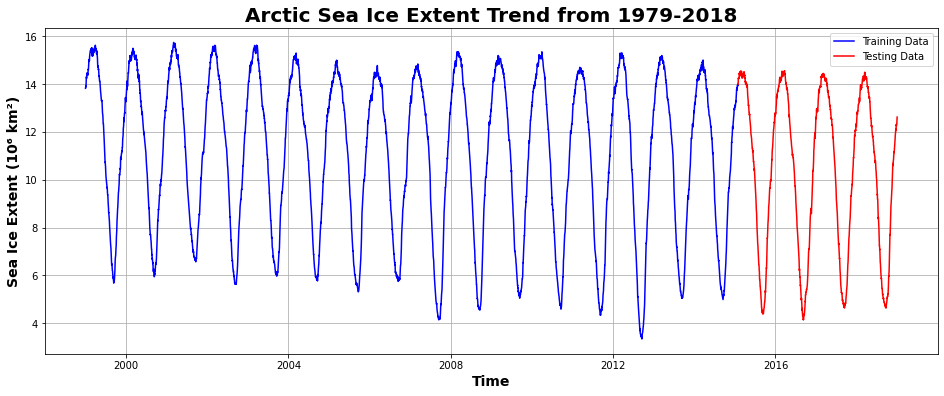

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14784     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 121,921
Trainable params: 121,921
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0304 - mae: 0.1173 - mse: 0.0304

81/81 [==============================] - 10s 19ms/step - loss: 0.0294 - mae: 0.1151 - mse: 0.0294 - val_loss: 0.0019 - val_mae: 0.0330 - val_mse: 0.0019
Epoch 2/100
79/81 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0658 - mse: 0.0068

81/81 [==============================] - 1s 7ms/step - loss: 0.0068 - mae: 0.0658 - mse: 0.0068 - val_loss: 0.0016 - val_mae: 0.0301 - val_mse: 0.0016
Epoch 3/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0056 - mae: 0.0598 - mse: 0.0056

81/81 [==============================] - 1s 8ms/step - loss: 0.0055 - mae: 0.0596 - mse: 0.0055 - val_loss: 0.0013 - val_mae: 0.0316 - val_mse: 0.0013
Epoch 4/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0046 - mae: 0.0547 - mse: 0.0046

81/81 [==============================] - 1s 8ms/step - loss: 0.0046 - mae: 0.0546 - mse: 0.0046 - val_loss: 8.5572e-04 - val_mae: 0.0238 - val_mse: 8.5572e-04
Epoch 5/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0044 - mae: 0.0530 - mse: 0.0044

81/81 [==============================] - 1s 8ms/step - loss: 0.0044 - mae: 0.0528 - mse: 0.0044 - val_loss: 6.4185e-04 - val_mae: 0.0212 - val_mse: 6.4185e-04
Epoch 6/100
79/81 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0495 - mse: 0.0039

81/81 [==============================] - 1s 7ms/step - loss: 0.0039 - mae: 0.0494 - mse: 0.0039 - val_loss: 0.0012 - val_mae: 0.0279 - val_mse: 0.0012
Epoch 7/100
80/81 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0479 - mse: 0.0036

81/81 [==============================] - 1s 7ms/step - loss: 0.0036 - mae: 0.0479 - mse: 0.0036 - val_loss: 8.0081e-04 - val_mae: 0.0226 - val_mse: 8.0081e-04
Epoch 8/100
79/81 [============================>.] - ETA: 0s - loss: 0.0035 - mae: 0.0471 - mse: 0.0035

81/81 [==============================] - 1s 8ms/step - loss: 0.0035 - mae: 0.0471 - mse: 0.0035 - val_loss: 5.6587e-04 - val_mae: 0.0193 - val_mse: 5.6587e-04
Epoch 9/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0034 - mae: 0.0461 - mse: 0.0034

81/81 [==============================] - 1s 7ms/step - loss: 0.0034 - mae: 0.0459 - mse: 0.0034 - val_loss: 0.0012 - val_mae: 0.0287 - val_mse: 0.0012
Epoch 10/100
80/81 [============================>.] - ETA: 0s - loss: 0.0035 - mae: 0.0465 - mse: 0.0035

81/81 [==============================] - 1s 7ms/step - loss: 0.0035 - mae: 0.0464 - mse: 0.0035 - val_loss: 0.0018 - val_mae: 0.0342 - val_mse: 0.0018
Epoch 11/100
80/81 [============================>.] - ETA: 0s - loss: 0.0032 - mae: 0.0453 - mse: 0.0032

81/81 [==============================] - 1s 7ms/step - loss: 0.0032 - mae: 0.0453 - mse: 0.0032 - val_loss: 8.0908e-04 - val_mae: 0.0241 - val_mse: 8.0908e-04
Epoch 12/100
80/81 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0427 - mse: 0.0030

81/81 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0427 - mse: 0.0030 - val_loss: 0.0012 - val_mae: 0.0297 - val_mse: 0.0012
Epoch 13/100
79/81 [============================>.] - ETA: 0s - loss: 0.0028 - mae: 0.0414 - mse: 0.0028

81/81 [==============================] - 1s 7ms/step - loss: 0.0028 - mae: 0.0414 - mse: 0.0028 - val_loss: 0.0012 - val_mae: 0.0277 - val_mse: 0.0012
Epoch 14/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0409 - mse: 0.0027

81/81 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0408 - mse: 0.0027 - val_loss: 0.0011 - val_mae: 0.0259 - val_mse: 0.0011
Epoch 15/100
80/81 [============================>.] - ETA: 0s - loss: 0.0027 - mae: 0.0403 - mse: 0.0027

81/81 [==============================] - 1s 7ms/step - loss: 0.0026 - mae: 0.0403 - mse: 0.0026 - val_loss: 0.0010 - val_mae: 0.0272 - val_mse: 0.0010
Epoch 16/100
79/81 [============================>.] - ETA: 0s - loss: 0.0027 - mae: 0.0402 - mse: 0.0027

81/81 [==============================] - 1s 7ms/step - loss: 0.0027 - mae: 0.0402 - mse: 0.0027 - val_loss: 9.8188e-04 - val_mae: 0.0247 - val_mse: 9.8188e-04
Epoch 17/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0387 - mse: 0.0024

81/81 [==============================] - 1s 7ms/step - loss: 0.0024 - mae: 0.0389 - mse: 0.0024 - val_loss: 7.4050e-04 - val_mae: 0.0222 - val_mse: 7.4050e-04
Epoch 18/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0382 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0382 - mse: 0.0024 - val_loss: 6.9470e-04 - val_mae: 0.0208 - val_mse: 6.9470e-04
Epoch 19/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0367 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0367 - mse: 0.0022 - val_loss: 0.0014 - val_mae: 0.0290 - val_mse: 0.0014
Epoch 20/100
80/81 [============================>.] - ETA: 0s - loss: 0.0024 - mae: 0.0382 - mse: 0.0024

81/81 [==============================] - 1s 7ms/step - loss: 0.0025 - mae: 0.0384 - mse: 0.0025 - val_loss: 0.0013 - val_mae: 0.0304 - val_mse: 0.0013
Epoch 21/100
81/81 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0377 - mse: 0.0023

81/81 [==============================] - 1s 7ms/step - loss: 0.0023 - mae: 0.0377 - mse: 0.0023 - val_loss: 8.6113e-04 - val_mae: 0.0226 - val_mse: 8.6113e-04
Epoch 22/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0357 - mse: 0.0021

81/81 [==============================] - 1s 7ms/step - loss: 0.0021 - mae: 0.0358 - mse: 0.0021 - val_loss: 0.0012 - val_mae: 0.0272 - val_mse: 0.0012
Epoch 23/100
79/81 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0355 - mse: 0.0021

81/81 [==============================] - 1s 7ms/step - loss: 0.0021 - mae: 0.0356 - mse: 0.0021 - val_loss: 0.0013 - val_mae: 0.0277 - val_mse: 0.0013
Epoch 24/100
79/81 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0356 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0356 - mse: 0.0021 - val_loss: 0.0014 - val_mae: 0.0297 - val_mse: 0.0014
Epoch 25/100
81/81 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0349 - mse: 0.0020

81/81 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0349 - mse: 0.0020 - val_loss: 0.0013 - val_mae: 0.0264 - val_mse: 0.0013
Epoch 26/100
80/81 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0347 - mse: 0.0020

81/81 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0347 - mse: 0.0020 - val_loss: 9.4493e-04 - val_mae: 0.0243 - val_mse: 9.4493e-04
Epoch 27/100
80/81 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0347 - mse: 0.0020

81/81 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0348 - mse: 0.0020 - val_loss: 0.0013 - val_mae: 0.0288 - val_mse: 0.0013
Epoch 28/100
79/81 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0347 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0346 - mse: 0.0020 - val_loss: 0.0011 - val_mae: 0.0275 - val_mse: 0.0011
Epoch 29/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0333 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0332 - mse: 0.0019 - val_loss: 0.0014 - val_mae: 0.0290 - val_mse: 0.0014
Epoch 30/100
80/81 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0330 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0330 - mse: 0.0018 - val_loss: 0.0015 - val_mae: 0.0316 - val_mse: 0.0015
Epoch 31/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0326 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0325 - mse: 0.0018 - val_loss: 9.2801e-04 - val_mae: 0.0242 - val_mse: 9.2801e-04
Epoch 32/100
80/81 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0340 - mse: 0.0019

81/81 [==============================] - 1s 7ms/step - loss: 0.0019 - mae: 0.0340 - mse: 0.0019 - val_loss: 0.0014 - val_mae: 0.0268 - val_mse: 0.0014
Epoch 33/100
80/81 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0342 - mse: 0.0020

81/81 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0342 - mse: 0.0020 - val_loss: 0.0011 - val_mae: 0.0250 - val_mse: 0.0011
Epoch 34/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0325 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0324 - mse: 0.0017 - val_loss: 0.0016 - val_mae: 0.0317 - val_mse: 0.0016
Epoch 35/100
79/81 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0317 - mse: 0.0017

81/81 [==============================] - 1s 7ms/step - loss: 0.0017 - mae: 0.0317 - mse: 0.0017 - val_loss: 0.0011 - val_mae: 0.0242 - val_mse: 0.0011
Epoch 36/100
80/81 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0332 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0331 - mse: 0.0018 - val_loss: 0.0016 - val_mae: 0.0286 - val_mse: 0.0016
Epoch 37/100
80/81 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0305 - mse: 0.0016

81/81 [==============================] - 1s 7ms/step - loss: 0.0016 - mae: 0.0305 - mse: 0.0016 - val_loss: 0.0013 - val_mae: 0.0268 - val_mse: 0.0013
Epoch 38/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0307 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0308 - mse: 0.0016 - val_loss: 0.0015 - val_mae: 0.0316 - val_mse: 0.0015
Epoch 39/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0306 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0306 - mse: 0.0016 - val_loss: 0.0023 - val_mae: 0.0374 - val_mse: 0.0023
Epoch 40/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0317 - mse: 0.0017

81/81 [==============================] - 1s 9ms/step - loss: 0.0017 - mae: 0.0318 - mse: 0.0017 - val_loss: 0.0014 - val_mae: 0.0275 - val_mse: 0.0014
Epoch 41/100
81/81 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0310 - mse: 0.0016

81/81 [==============================] - 1s 11ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 0.0014 - val_mae: 0.0265 - val_mse: 0.0014
Epoch 42/100
79/81 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0295 - mse: 0.0015

81/81 [==============================] - 1s 11ms/step - loss: 0.0015 - mae: 0.0296 - mse: 0.0015 - val_loss: 0.0011 - val_mae: 0.0250 - val_mse: 0.0011
Epoch 43/100
81/81 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0311 - mse: 0.0016

81/81 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0311 - mse: 0.0016 - val_loss: 0.0012 - val_mae: 0.0258 - val_mse: 0.0012
Epoch 44/100
79/81 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0296 - mse: 0.0015

81/81 [==============================] - 1s 7ms/step - loss: 0.0015 - mae: 0.0296 - mse: 0.0015 - val_loss: 0.0013 - val_mae: 0.0270 - val_mse: 0.0013
Epoch 45/100
80/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0288 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 0.0014 - val_mae: 0.0328 - val_mse: 0.0014
Epoch 46/100
80/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0289 - mse: 0.0014 - val_loss: 0.0023 - val_mae: 0.0355 - val_mse: 0.0023
Epoch 47/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0286 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0286 - mse: 0.0014 - val_loss: 0.0017 - val_mae: 0.0318 - val_mse: 0.0017
Epoch 48/100
79/81 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0295 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0295 - mse: 0.0015 - val_loss: 0.0012 - val_mae: 0.0262 - val_mse: 0.0012
Epoch 49/100
79/81 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0303 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0302 - mse: 0.0015 - val_loss: 0.0020 - val_mae: 0.0348 - val_mse: 0.0020
Epoch 50/100
79/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0296 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0296 - mse: 0.0014 - val_loss: 0.0014 - val_mae: 0.0280 - val_mse: 0.0014
Epoch 51/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0299 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0014 - val_mae: 0.0268 - val_mse: 0.0014
Epoch 52/100
80/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0280 - mse: 0.0013

81/81 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0280 - mse: 0.0013 - val_loss: 0.0014 - val_mae: 0.0280 - val_mse: 0.0014
Epoch 53/100
80/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0283 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0282 - mse: 0.0013 - val_loss: 0.0018 - val_mae: 0.0325 - val_mse: 0.0018
Epoch 54/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0291 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0291 - mse: 0.0014 - val_loss: 0.0016 - val_mae: 0.0308 - val_mse: 0.0016
Epoch 55/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0286 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0285 - mse: 0.0014 - val_loss: 0.0011 - val_mae: 0.0236 - val_mse: 0.0011
Epoch 56/100
80/81 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - val_loss: 0.0016 - val_mae: 0.0288 - val_mse: 0.0016
Epoch 57/100
79/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0278 - mse: 0.0013

81/81 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0278 - mse: 0.0013 - val_loss: 0.0018 - val_mae: 0.0304 - val_mse: 0.0018
Epoch 58/100
80/81 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0296 - mse: 0.0015

81/81 [==============================] - 1s 7ms/step - loss: 0.0015 - mae: 0.0296 - mse: 0.0015 - val_loss: 0.0016 - val_mae: 0.0311 - val_mse: 0.0016
Epoch 59/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0268 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012 - val_loss: 0.0025 - val_mae: 0.0383 - val_mse: 0.0025
Epoch 60/100
79/81 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0270 - mse: 0.0012 - val_loss: 0.0017 - val_mae: 0.0309 - val_mse: 0.0017
Epoch 61/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0275 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 0.0023 - val_mae: 0.0383 - val_mse: 0.0023
Epoch 62/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 0.0014 - val_mae: 0.0276 - val_mse: 0.0014
Epoch 63/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0261 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0261 - mse: 0.0011 - val_loss: 0.0019 - val_mae: 0.0335 - val_mse: 0.0019
Epoch 64/100
79/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0281 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0280 - mse: 0.0014 - val_loss: 0.0020 - val_mae: 0.0343 - val_mse: 0.0020
Epoch 65/100
79/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0261 - mse: 0.0011

81/81 [==============================] - 1s 7ms/step - loss: 0.0011 - mae: 0.0262 - mse: 0.0011 - val_loss: 0.0024 - val_mae: 0.0356 - val_mse: 0.0024
Epoch 66/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0276 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0275 - mse: 0.0013 - val_loss: 0.0018 - val_mae: 0.0311 - val_mse: 0.0018
Epoch 67/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0251 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0252 - mse: 0.0011 - val_loss: 0.0022 - val_mae: 0.0361 - val_mse: 0.0022
Epoch 68/100
80/81 [============================>.] - ETA: 0s - loss: 9.9261e-04 - mae: 0.0247 - mse: 9.9261e-04

81/81 [==============================] - 1s 7ms/step - loss: 9.9229e-04 - mae: 0.0247 - mse: 9.9229e-04 - val_loss: 0.0015 - val_mae: 0.0306 - val_mse: 0.0015
Epoch 69/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0258 - mse: 0.0011 - val_loss: 0.0013 - val_mae: 0.0272 - val_mse: 0.0013
Epoch 70/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012 - val_loss: 0.0018 - val_mae: 0.0308 - val_mse: 0.0018
Epoch 71/100
79/81 [============================>.] - ETA: 0s - loss: 9.9501e-04 - mae: 0.0249 - mse: 9.9501e-04

81/81 [==============================] - 1s 7ms/step - loss: 9.9676e-04 - mae: 0.0249 - mse: 9.9676e-04 - val_loss: 0.0020 - val_mae: 0.0339 - val_mse: 0.0020
Epoch 72/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0254 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0255 - mse: 0.0011 - val_loss: 0.0013 - val_mae: 0.0280 - val_mse: 0.0013
Epoch 73/100
79/81 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0251 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0251 - mse: 0.0010 - val_loss: 0.0027 - val_mae: 0.0423 - val_mse: 0.0027
Epoch 74/100
79/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0262 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0262 - mse: 0.0011 - val_loss: 0.0019 - val_mae: 0.0350 - val_mse: 0.0019
Epoch 75/100
74/81 [==========================>...] - ETA: 0s - loss: 8.8962e-04 - mae: 0.0234 - mse: 8.8962e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.8293e-04 - mae: 0.0233 - mse: 8.8293e-04 - val_loss: 0.0018 - val_mae: 0.0331 - val_mse: 0.0018
Epoch 76/100
77/81 [===========================>..] - ETA: 0s - loss: 9.7047e-04 - mae: 0.0244 - mse: 9.7047e-04

81/81 [==============================] - 1s 12ms/step - loss: 9.6786e-04 - mae: 0.0243 - mse: 9.6786e-04 - val_loss: 0.0017 - val_mae: 0.0307 - val_mse: 0.0017
Epoch 77/100
81/81 [==============================] - ETA: 0s - loss: 9.7807e-04 - mae: 0.0246 - mse: 9.7807e-04

81/81 [==============================] - 1s 10ms/step - loss: 9.7807e-04 - mae: 0.0246 - mse: 9.7807e-04 - val_loss: 0.0024 - val_mae: 0.0374 - val_mse: 0.0024
Epoch 78/100
79/81 [============================>.] - ETA: 0s - loss: 9.4048e-04 - mae: 0.0240 - mse: 9.4048e-04

81/81 [==============================] - 1s 14ms/step - loss: 9.4212e-04 - mae: 0.0240 - mse: 9.4212e-04 - val_loss: 0.0020 - val_mae: 0.0348 - val_mse: 0.0020
Epoch 79/100
80/81 [============================>.] - ETA: 0s - loss: 9.5434e-04 - mae: 0.0242 - mse: 9.5434e-04

81/81 [==============================] - 1s 12ms/step - loss: 9.5674e-04 - mae: 0.0242 - mse: 9.5674e-04 - val_loss: 0.0019 - val_mae: 0.0335 - val_mse: 0.0019
Epoch 80/100
80/81 [============================>.] - ETA: 0s - loss: 9.3211e-04 - mae: 0.0240 - mse: 9.3211e-04

81/81 [==============================] - 1s 10ms/step - loss: 9.3002e-04 - mae: 0.0240 - mse: 9.3002e-04 - val_loss: 0.0017 - val_mae: 0.0315 - val_mse: 0.0017
Epoch 81/100
80/81 [============================>.] - ETA: 0s - loss: 9.8433e-04 - mae: 0.0243 - mse: 9.8433e-04

81/81 [==============================] - 1s 7ms/step - loss: 9.8531e-04 - mae: 0.0243 - mse: 9.8531e-04 - val_loss: 0.0018 - val_mae: 0.0337 - val_mse: 0.0018
Epoch 82/100
76/81 [===========================>..] - ETA: 0s - loss: 9.1895e-04 - mae: 0.0234 - mse: 9.1895e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.0964e-04 - mae: 0.0233 - mse: 9.0964e-04 - val_loss: 0.0018 - val_mae: 0.0324 - val_mse: 0.0018
Epoch 83/100
80/81 [============================>.] - ETA: 0s - loss: 8.9657e-04 - mae: 0.0234 - mse: 8.9657e-04

81/81 [==============================] - 1s 7ms/step - loss: 8.9702e-04 - mae: 0.0234 - mse: 8.9702e-04 - val_loss: 0.0017 - val_mae: 0.0333 - val_mse: 0.0017
Epoch 84/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0248 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0246 - mse: 0.0011 - val_loss: 0.0020 - val_mae: 0.0323 - val_mse: 0.0020
Epoch 85/100
76/81 [===========================>..] - ETA: 0s - loss: 8.1955e-04 - mae: 0.0223 - mse: 8.1955e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.1956e-04 - mae: 0.0223 - mse: 8.1956e-04 - val_loss: 0.0021 - val_mae: 0.0354 - val_mse: 0.0021
Epoch 86/100
77/81 [===========================>..] - ETA: 0s - loss: 8.7066e-04 - mae: 0.0229 - mse: 8.7066e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.7800e-04 - mae: 0.0230 - mse: 8.7800e-04 - val_loss: 0.0021 - val_mae: 0.0353 - val_mse: 0.0021
Epoch 87/100
80/81 [============================>.] - ETA: 0s - loss: 7.8287e-04 - mae: 0.0218 - mse: 7.8287e-04

81/81 [==============================] - 1s 7ms/step - loss: 7.8137e-04 - mae: 0.0218 - mse: 7.8137e-04 - val_loss: 0.0017 - val_mae: 0.0307 - val_mse: 0.0017
Epoch 88/100
76/81 [===========================>..] - ETA: 0s - loss: 8.4741e-04 - mae: 0.0227 - mse: 8.4741e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.5461e-04 - mae: 0.0227 - mse: 8.5461e-04 - val_loss: 0.0023 - val_mae: 0.0367 - val_mse: 0.0023
Epoch 89/100
75/81 [==========================>...] - ETA: 0s - loss: 8.0621e-04 - mae: 0.0221 - mse: 8.0621e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.4438e-04 - mae: 0.0224 - mse: 8.4438e-04 - val_loss: 0.0018 - val_mae: 0.0329 - val_mse: 0.0018
Epoch 90/100
80/81 [============================>.] - ETA: 0s - loss: 9.8303e-04 - mae: 0.0244 - mse: 9.8303e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.8055e-04 - mae: 0.0243 - mse: 9.8055e-04 - val_loss: 0.0014 - val_mae: 0.0283 - val_mse: 0.0014
Epoch 91/100
77/81 [===========================>..] - ETA: 0s - loss: 9.2358e-04 - mae: 0.0235 - mse: 9.2358e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.1953e-04 - mae: 0.0234 - mse: 9.1953e-04 - val_loss: 0.0028 - val_mae: 0.0399 - val_mse: 0.0028
Epoch 92/100
74/81 [==========================>...] - ETA: 0s - loss: 7.9357e-04 - mae: 0.0219 - mse: 7.9357e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.0301e-04 - mae: 0.0220 - mse: 8.0301e-04 - val_loss: 0.0021 - val_mae: 0.0347 - val_mse: 0.0021
Epoch 93/100
80/81 [============================>.] - ETA: 0s - loss: 7.3134e-04 - mae: 0.0212 - mse: 7.3134e-04

81/81 [==============================] - 1s 8ms/step - loss: 7.3083e-04 - mae: 0.0212 - mse: 7.3083e-04 - val_loss: 0.0030 - val_mae: 0.0417 - val_mse: 0.0030
Epoch 94/100
79/81 [============================>.] - ETA: 0s - loss: 7.9982e-04 - mae: 0.0219 - mse: 7.9982e-04

81/81 [==============================] - 1s 9ms/step - loss: 7.9733e-04 - mae: 0.0219 - mse: 7.9733e-04 - val_loss: 0.0024 - val_mae: 0.0369 - val_mse: 0.0024
Epoch 95/100
81/81 [==============================] - ETA: 0s - loss: 6.8073e-04 - mae: 0.0203 - mse: 6.8073e-04

81/81 [==============================] - 1s 8ms/step - loss: 6.8073e-04 - mae: 0.0203 - mse: 6.8073e-04 - val_loss: 0.0029 - val_mae: 0.0400 - val_mse: 0.0029
Epoch 96/100
75/81 [==========================>...] - ETA: 0s - loss: 8.7607e-04 - mae: 0.0231 - mse: 8.7607e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.6285e-04 - mae: 0.0229 - mse: 8.6285e-04 - val_loss: 0.0023 - val_mae: 0.0365 - val_mse: 0.0023
Epoch 97/100
79/81 [============================>.] - ETA: 0s - loss: 7.1860e-04 - mae: 0.0211 - mse: 7.1860e-04

81/81 [==============================] - 1s 8ms/step - loss: 7.1993e-04 - mae: 0.0211 - mse: 7.1993e-04 - val_loss: 0.0028 - val_mae: 0.0387 - val_mse: 0.0028
Epoch 98/100
78/81 [===========================>..] - ETA: 0s - loss: 7.7128e-04 - mae: 0.0218 - mse: 7.7128e-04

81/81 [==============================] - 1s 10ms/step - loss: 7.6722e-04 - mae: 0.0217 - mse: 7.6722e-04 - val_loss: 0.0031 - val_mae: 0.0423 - val_mse: 0.0031
Epoch 99/100
79/81 [============================>.] - ETA: 0s - loss: 7.1539e-04 - mae: 0.0207 - mse: 7.1539e-04

81/81 [==============================] - 1s 12ms/step - loss: 7.1830e-04 - mae: 0.0208 - mse: 7.1830e-04 - val_loss: 0.0020 - val_mae: 0.0351 - val_mse: 0.0020
Epoch 100/100
76/81 [===========================>..] - ETA: 0s - loss: 6.9303e-04 - mae: 0.0204 - mse: 6.9303e-04

81/81 [==============================] - 1s 15ms/step - loss: 6.9628e-04 - mae: 0.0205 - mse: 6.9628e-04 - val_loss: 0.0027 - val_mae: 0.0379 - val_mse: 0.0027


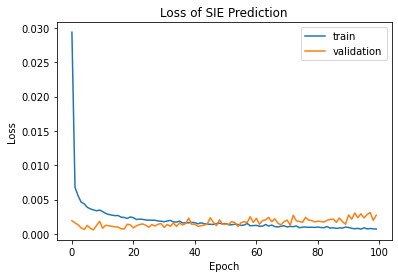

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

45/45 [==============================] - 1s 4ms/step


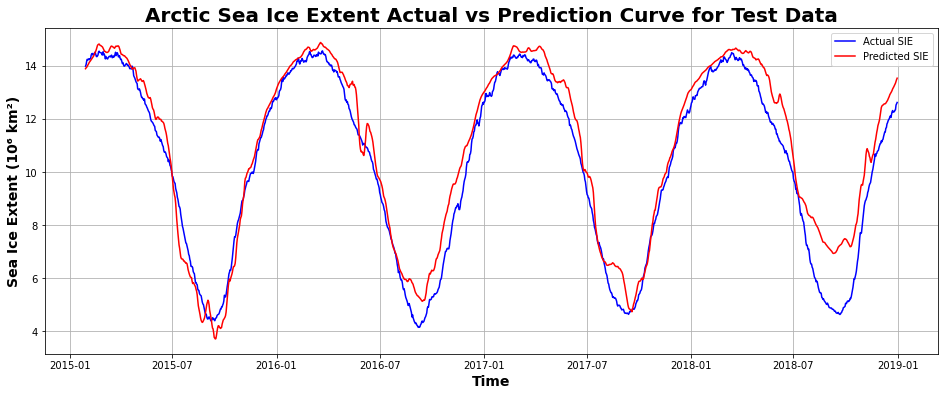

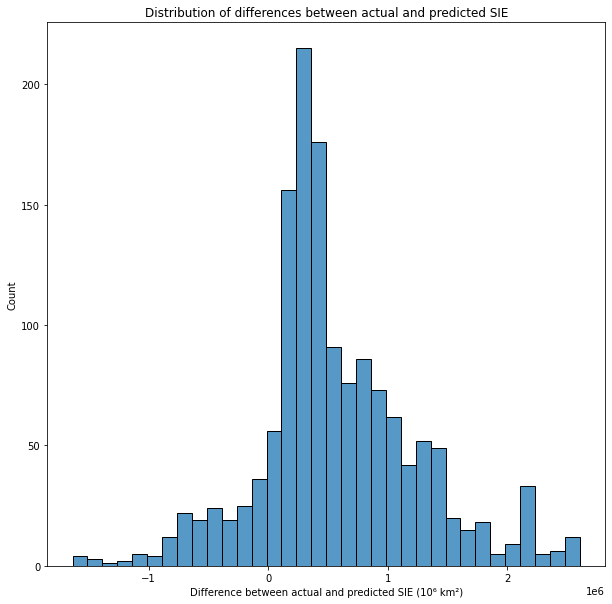

MSE :  773050574491.5127 (10⁶ km²)
MSPE : 1.8791873761342652 %
RMSE :  879232.9466594803 (10⁶ km²)
RMSPE : 13.708345546178302 %
MAE :  687238.6140963015 (10⁶ km²)
MAPE :  7.659406149506866 %
R2 :  0.9286530945126767


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [15]:
# while True:pass